In [1]:
import matplotlib.pyplot as plt 
from scipy.stats import truncnorm
from sklearn.metrics import roc_curve, auc

import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.weight_norm as weight_norm
import numpy as np
import math
from torchcfm.optimal_transport import OTPlanSampler
from torchdyn.core import NeuralODE
from torch.utils.data import DataLoader

# --- MASKING UTILITIES ---
def create_mask(batch):
    return (batch.abs().sum(dim=-1) > 0).float()

def get_multiplicity_distribution(dataset):
    counts = (dataset[:, :, 0] != 0).sum(axis=1)
    unique, freqs = np.unique(counts, return_counts=True)
    prob = freqs / freqs.sum()
    return unique, prob

# --- TIME EMBEDDING ---
def timestep_sinusoidal_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = torch.exp(-math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32, device=timesteps.device) / half)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

class EPiC_layer(nn.Module):
    def __init__(self, local_in_dim, hid_dim, latent_dim, context_dim):
        super(EPiC_layer, self).__init__()
        self.fc_global1 = weight_norm(nn.Linear(2 * hid_dim + latent_dim, hid_dim)) 
        self.fc_global2 = weight_norm(nn.Linear(hid_dim, latent_dim)) 
        self.fc_local1 = weight_norm(nn.Linear(local_in_dim + latent_dim + context_dim, hid_dim))
        self.fc_local2 = weight_norm(nn.Linear(hid_dim, hid_dim))

    def forward(self, x_global, x_local, context, mask):
        """
        Args:
            x_global: (batch, latent_dim)
            x_local:  (batch, num_points, hid_dim)
            context:  (batch, num_points, context_dim)
            mask:     (batch, num_points, 1) — float or bool mask
        Returns:
            x_global, x_local: updated latent/global features
        """
        # --- Mask-aware pooling ---
        masked_local = x_local * mask  # (B, N, D)
        sum_pool = masked_local.sum(1)  # (B, D)
        count = mask.sum(1).clamp(min=1e-6)  # (B, 1)
        mean_pool = sum_pool / count  # (B, D)

        # --- Global update ---
        x_pooledCATglobal = torch.cat([mean_pool, sum_pool*0.1, x_global], dim=1)  # (B, 2*D + latent)
        x_global1 = F.leaky_relu(self.fc_global1(x_pooledCATglobal))
        x_global = F.leaky_relu(self.fc_global2(x_global1) + x_global)

        # --- Local update ---
        B, N, _ = x_local.shape
        x_global2local = x_global.unsqueeze(1).expand(-1, N, -1)  # (B, N, latent)
        x_localCATglobal = torch.cat([x_local, x_global2local, context], dim=-1)  # (B, N, D+latent+context)
        x_local1 = F.leaky_relu(self.fc_local1(x_localCATglobal))
        x_local = F.leaky_relu(self.fc_local2(x_local1) + x_local)

        return x_global, x_local


class EPiC_Projection(nn.Module):
    def __init__(self, dim_latent_global, latent_local, dim_hidden):
        super(EPiC_Projection, self).__init__()
        self.local_0 = weight_norm(nn.Linear(latent_local, dim_hidden))
        self.global_0 = weight_norm(nn.Linear(2 * dim_hidden, dim_hidden))
        self.global_1 = weight_norm(nn.Linear(dim_hidden, dim_hidden))
        self.global_2 = weight_norm(nn.Linear(dim_hidden, dim_latent_global))

    def meansum_pooling(self, x_local, mask):
        mask = mask.float()
        masked_x = x_local * mask
        sum_pool = masked_x.sum(1)
        count = mask.sum(1).clamp(min=1e-6)
        mean_pool = sum_pool / count
        return torch.cat([mean_pool, sum_pool*0.1], dim=-1)

    def forward(self, x_local, mask):
        x_local = F.leaky_relu(self.local_0(x_local.float()))
        x_global = self.meansum_pooling(x_local, mask)
        x_global = F.leaky_relu(self.global_0(x_global))
        x_global = F.leaky_relu(self.global_1(x_global))
        x_global = F.leaky_relu(self.global_2(x_global))
        return x_global, x_local

class EPiC_Network(nn.Module):
    def __init__(self, dim_features=2, dim_latent_global=16, time_embedding='sinusoidal', dim_time_embedding=16, dim_hidden=128, num_layers=4, skip_connection=True):
        super(EPiC_Network, self).__init__()
        self.time_embedding = time_embedding
        self.dim_time_embedding = dim_time_embedding
        self.num_layers = num_layers
        self.skip_connection = skip_connection
        self.epic_proj = EPiC_Projection(dim_latent_global, dim_features + dim_time_embedding, dim_hidden)
        self.epic_layers = nn.ModuleList([
            EPiC_layer(local_in_dim=dim_hidden, hid_dim=dim_hidden, latent_dim=dim_latent_global, context_dim=dim_time_embedding)
            for _ in range(num_layers)
        ])
        self.output = weight_norm(nn.Linear(dim_hidden, dim_features))

    def forward(self, t, x, mask=None):
        if mask is None:
            mask = (x.abs().sum(dim=-1) > 0).float()
        mask = mask.unsqueeze(-1)

        # Time embedding
        if t.dim() == 2 and t.shape[1] == 1:
            t = t.squeeze(1)
        t_emb = timestep_sinusoidal_embedding(t, self.dim_time_embedding)
        t_rep = t_emb.unsqueeze(1).expand(-1, x.shape[1], -1)
    
        x_local = torch.cat([x, t_rep], dim=-1) * mask

        x_global, x_local = self.epic_proj(x_local, mask)

        if self.skip_connection:
            x_global_skip = x_global.clone()
            x_local_skip = x_local.clone()

        # EPiC blocks with proper masked layer call
        for layer in self.epic_layers:
            x_global, x_local = layer(x_global, x_local * mask, t_rep * mask, mask)
            if self.skip_connection:
                x_global += x_global_skip
                x_local = (x_local + x_local_skip) * mask  # ensure masking is reapplied

        return self.output(x_local) * mask


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions import Normal
from torch.func import vmap, jacrev
from tqdm import tqdm
import scipy

# --------------------------------------------
# Load trained models
# -------------------------------------------

device = 'cuda' if torch.cuda.is_available() else 'cpu'

signal_model = EPiC_Network().to(device)
background_model = EPiC_Network().to(device)

signal_model.load_state_dict(torch.load("checkpoints/epic_signal_model.pth"))
background_model.load_state_dict(torch.load("checkpoints/epic_background_model.pth"))

signal_model.eval()
background_model.eval()


/home/yp325/miniconda3/envs/torchcfm/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/tmp/ipykernel_1047542/270665787.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights

EPiC_Network(
  (epic_proj): EPiC_Projection(
    (local_0): Linear(in_features=18, out_features=128, bias=True)
    (global_0): Linear(in_features=256, out_features=128, bias=True)
    (global_1): Linear(in_features=128, out_features=128, bias=True)
    (global_2): Linear(in_features=128, out_features=16, bias=True)
  )
  (epic_layers): ModuleList(
    (0-3): 4 x EPiC_layer(
      (fc_global1): Linear(in_features=272, out_features=128, bias=True)
      (fc_global2): Linear(in_features=128, out_features=16, bias=True)
      (fc_local1): Linear(in_features=160, out_features=128, bias=True)
      (fc_local2): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (output): Linear(in_features=128, out_features=2, bias=True)
)

In [3]:
def make_ref_data(nevents,scale,mean):
    #first: the pTs
    # this gets a uniform sampling of the surface of a 9d hypersphere
    # see https://mathworld.wolfram.com/HyperspherePointPicking.html
    ndim= 10
    pT=np.random.normal(size=(nevents,ndim))
    pT=pT/np.sqrt(np.sum(pT**2,axis=-1).reshape((-1,1))) 
    # take the positive quadrant
    pT=np.abs(pT)
    # rescale by m sampled from (truncated) gaussian
    m=np.empty((0))
    while(len(m)<len(pT)):
        temptemp=scale*np.random.normal(size=(10000))+mean
        m=np.concatenate((m,temptemp[(temptemp>0)]))
    m=m[:len(pT)]
    pT=pT*(m.reshape((-1,1)))    

    # then the etas
    eta=np.random.normal(size=(nevents,ndim))*(1+pT*0.5)

    refdata=np.dstack((pT,eta))

    return refdata


sigdata = make_ref_data(1000, 0.3, 1.0)
bgdata = make_ref_data(1000, 0.3, 0.5)


In [4]:
pt_mean, pt_std = -2.173596811742521, 1.2937464746136649
eta_mean, eta_std = 0.00036626372231370215, 1.1025602142150686

log_sigpt = np.log(sigdata[:, :, 0])
log_bgpt = np.log(bgdata[:, :, 0])

preproc_sig = np.stack([
    (log_sigpt - pt_mean) / pt_std,
    (sigdata[:, :, 1] - eta_mean) / eta_std
], axis=-1)

preproc_bg = np.stack([
    (log_bgpt - pt_mean) / pt_std,
    (bgdata[:, :, 1] - eta_mean) / eta_std
], axis=-1)


In [5]:
def log_normal(x, mu=0.0, sigma=1.0):
    return Normal(mu, sigma).log_prob(x)

def create_mask(x):
    return (x.abs().sum(dim=-1) > 0).float()

def log_prob_euler(model, x, mask, steps=300):
    with torch.enable_grad():
        t_array = torch.linspace(1.0, 0.0, steps, device=x.device)
        h = t_array[1] - t_array[0]  # negative step size for backward integration
        z = x.clone().detach()
        int_div = torch.zeros(x.shape[0], device=x.device)

        for i in range(len(t_array) - 1):
            t_next = t_array[i + 1]  # move backward in time
            t_batch = torch.ones(z.shape[0], 1, device=z.device) * t_next

            # --- fixed-point iteration ---
            z_next = z.clone()
            for _ in range(1):
                with torch.no_grad():
                    vt = model(t=t_batch, x=z_next, mask=mask)
                    z_next = z + h * vt  # ✅ backward Euler

            # --- compute divergence trace using refined z_next ---
            def vf(z_, t_, m_):
                return model(t=t_.unsqueeze(0), x=z_.unsqueeze(0), mask=m_.unsqueeze(0)).squeeze(0)

            J = vmap(jacrev(vf, argnums=0), in_dims=(0, 0, 0))(z_next, t_batch, mask)
            B, N, F = z.shape
            J = J.reshape(B, N * F, N * F)
            trace = torch.diagonal(J, dim1=-1, dim2=-2).reshape(B, N, F)
            trace = (trace * mask.unsqueeze(-1)).sum(dim=(1, 2)).detach()

            z = z_next  # update state
            int_div += trace * h

        # --- base log-prob (standard normal prior) ---
        z_flat = z.view(B * N * F)
        mask_flat = mask.unsqueeze(-1).expand(-1, -1, F).reshape(B * N * F)
        log_z = (log_normal(z_flat) * mask_flat).reshape(B, N * F).sum(dim=1)

        return (log_z + int_div).detach().cpu().numpy()



In [6]:
def compute_logp_on_model(model, data, batch_size=512):
    model.eval()
    dataloader = DataLoader(torch.tensor(data, dtype=torch.float32), batch_size=batch_size)
    all_logp = []

    for x in tqdm(dataloader):
        x = x.to(device)
        mask = create_mask(x).to(device)
        logp = log_prob_euler(model, x, mask)
        all_logp.append(logp)

    return np.concatenate(all_logp)


In [7]:
logp_sig_on_sig = compute_logp_on_model(signal_model, preproc_sig)
logp_bg_on_bg   = compute_logp_on_model(background_model, preproc_bg)

100%|██████████| 2/2 [00:08<00:00,  4.08s/it]


In [8]:
def log_jacobian_correction(pt, eta, pt_std, eta_std):
    # pt and eta: shape (batch, 10)
    log_det_pt = -np.log(pt) - np.log(pt_std)  # shape (B, 10)
    log_det_eta = -np.log(eta_std) * np.ones_like(eta)  # shape (B, 10)
    log_det = log_det_pt + log_det_eta
    return np.sum(log_det, axis=1)  # sum over 10 particles

# Inputs: original (untransformed) pt, eta — shape (N, 10)
pt_sig = sigdata[:, :, 0]
eta_sig = sigdata[:, :, 1]

pt_bg = bgdata[:, :, 0]
eta_bg = bgdata[:, :, 1]

# Correction term
corr_sig = log_jacobian_correction(pt_sig, eta_sig, pt_std=pt_std, eta_std=eta_std)
corr_bg  = log_jacobian_correction(pt_bg, eta_bg, pt_std=pt_std, eta_std=eta_std)

# Corrected logp
corrected_logp_sig = logp_sig_on_sig + corr_sig 
corrected_logp_bg  = logp_bg_on_bg  + corr_bg 

In [9]:
import numpy as np
from scipy.special import erf, gamma
import math

sigscale=0.3
sigmean=1

bgscale=0.3
bgmean=0.5


def logp_ref(data,scale,mean):
    ndim=10
    r=np.sqrt(np.sum(data[:,:,0]**2,axis=-1))
    logp_r=-(r-mean)**2/(2*scale**2)\
                    -np.log(np.sqrt(np.pi*scale**2/2))-np.log(1+erf(mean/scale/np.sqrt(2)))
    logp_r-=(ndim-1)*np.log(r)
    logp=logp_r-np.log(2*np.pi**(ndim/2)/gamma(ndim/2)/2**ndim) # #-logp_phi
    logpeta=np.sum(-0.5*data[:,:,1]**2/(1+0.5*data[:,:,0])**2-np.log(np.sqrt(2*np.pi*(1+0.5*data[:,:,0])**2)),axis=-1)
    logp+=logpeta
    return logp

sig_ll_sigmodel = logp_ref(sigdata, sigmean, sigscale)
bg_ll_bgmodel = logp_ref(bgdata, bgmean, bgscale)

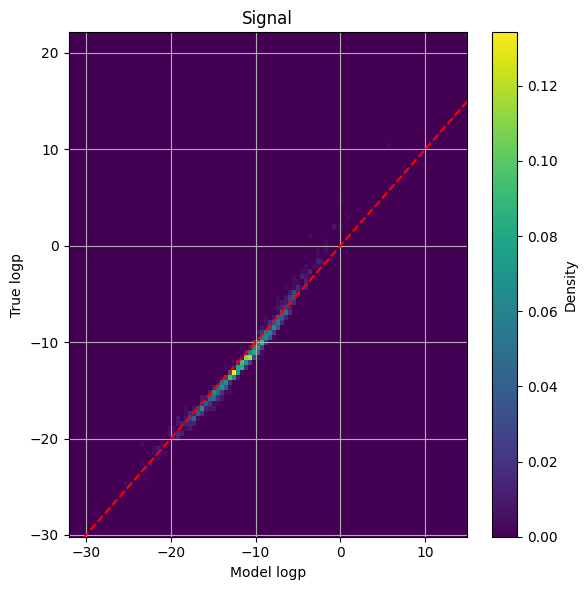

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Create 2D histogram
plt.figure(figsize=(6,6))
_ = plt.hist2d(corrected_logp_sig, sig_ll_sigmodel, bins=100, cmap='viridis',density=True)

# Diagonal line (y = x)
min_val = min(np.min(corrected_logp_sig), np.min(sig_ll_sigmodel))
max_val = max(np.max(corrected_logp_sig), np.max(sig_ll_sigmodel))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.xlabel('Model logp')
plt.ylabel('True logp')
plt.colorbar(label='Density')
plt.title("Signal")
plt.grid(True)
plt.tight_layout()
plt.show()


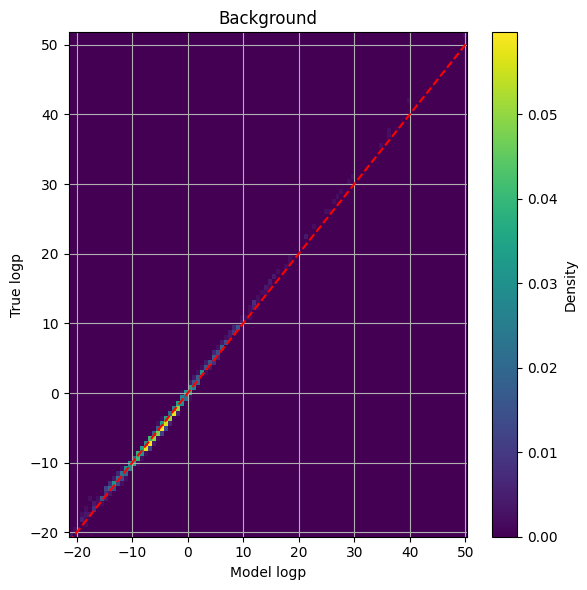

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Create 2D histogram
plt.figure(figsize=(6,6))
_ = plt.hist2d(corrected_logp_bg, bg_ll_bgmodel, bins=100, cmap='viridis',density=True)

# Diagonal line (y = x)
min_val = min(np.min(corrected_logp_bg), np.min(bg_ll_bgmodel))
max_val = max(np.max(corrected_logp_bg), np.max(bg_ll_bgmodel))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.xlabel('Model logp')
plt.ylabel('True logp')
plt.colorbar(label='Density')
plt.title("Background")
plt.grid(True)
plt.tight_layout()
plt.show()
